# Comparing Chl between SeaWIFS and CESM-LE Output
1. load data


In [36]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict

import calendar
import numpy as np
import xarray as xr
import xesmf as xe
import dask
from ncar_jobqueue import NCARCluster
import esmlab

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.path as mpath

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
style.use('ggplot')

import util
import shutil

In [3]:
'''
Ran once to create Zarr file from:

SeaWiFS data on the POP grid: along with the original data I interpolated from
is in /glade/p/cgd/oce/projects/cesm2-marbl/seaWIFS-data. 
The notebook that does the interpolation is 
https://github.com/mnlevy1981/cesm2-marbl/blob/
interpolate_chl_data/notebooks/chl_regrid/map%20chl%20to%20gx1v7.ipynb 
and the mapping file (the only part generated outside of python) is 
/glade/work/mlevy/codes/cesm2-marbl/notebooks/chl_regrid/scrip_grids/
weights/seaWIFS_to_POP_gx1v7_conservative.nc
'''
'''
#load Seawifs Data
seawifs_pop_file = '/glade/p/cgd/oce/projects/cesm2-marbl/seaWIFS-data/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.nc'

dsi = xr.open_dataset(seawifs_pop_file, decode_coords=False, decode_times=False, 
                            chunks={'nlon': 16})

file_out = 'data/seawifs/monthly_climatology/chl_gsm/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.zarr'
if os.path.exists(file_out):
    shutil.rmtree(file_out)
dsi.to_zarr(file_out);
'''

In [13]:
#Load Model Output from Compressed File processed in cesm-initial-look script
dsmod = xr.open_zarr('data/cesm-le-sst-chl.zarr').compute()
dsmod2 = xr.open_zarr('data/cesm-le-sst-chl-97-10.zarr').compute()
#Load Observational Data from Compressed File processed in Seawifs script
dsobs = xr.open_zarr('data/seawifs/monthly_climatology/chl_gsm/seaWIFS.chl_gsm.mon_climo.Sep1997_Dec2010.zarr').compute()
#dsobs = xr.open_zarr('data/seawifs/monthly_climatology/chl_gsm/seawifs_L3m_MC_GSM_chl_gsm_9km_global.zarr').compute()

## Notes on Data:
    
SeaWiFS Climatology is:
* Sept (1997 - 2010)
* Oct (1997 - 2010)
* Nov (1997 - 2010)
* Dec (1997 - 2010)
* Jan (1998 - 2010)
* Feb (1998 - 2010)
* March (1998 - 2010)
* April (1998 - 2010)
* May (1998 - 2010)
* June (1998 - 2010)
* July (1998 - 2010)
* Aug (1998 - 2010)

In [14]:
#make month variables match:
dsmod['month'] = dsobs['month']
dsmod2['month'] = dsobs['month']

### Compare the differences in the data formats:

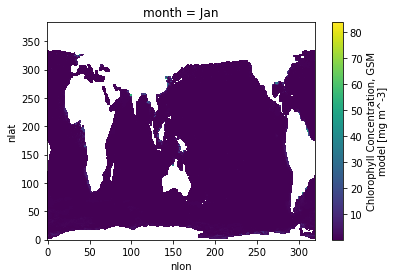

In [6]:
#plot Observational Data:
dsobs.chl_gsm.sel(month='Jan').plot();

obs data shape: (12, 384, 320) model data shape: (12, 384, 320)


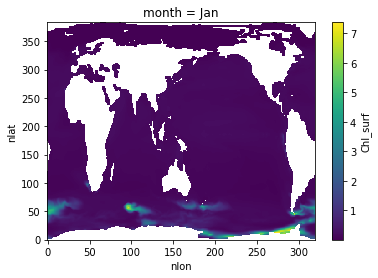

In [7]:
#plot CESM:
dsmod.Chl_surf.sel(month='Jan').plot();
print('obs data shape:', dsobs.chl_gsm.shape, 'model data shape:', dsmod.Chl_surf.shape)

obs data shape: (12, 384, 320) model data shape: (12, 384, 320)


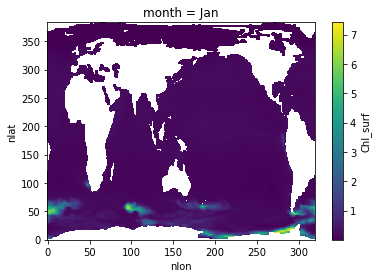

In [15]:
#plot CESM:
dsmod2.Chl_surf.sel(month='Jan').plot();
print('obs data shape:', dsobs.chl_gsm.shape, 'model data shape:', dsmod.Chl_surf.shape)

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


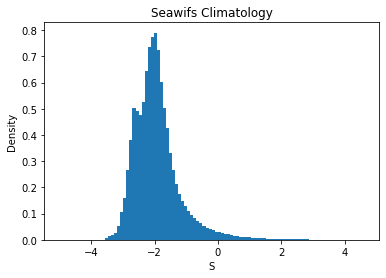

In [8]:
## Histograms of Seawifs
obs_log_trans = np.log(dsobs.chl_gsm.where(dsobs.chl_gsm>0))
plt.figure()
plt.hist(obs_log_trans.values.ravel(), 100, density=True);
plt.title('Seawifs Climatology')
plt.xlabel('S')
plt.ylabel('Density');

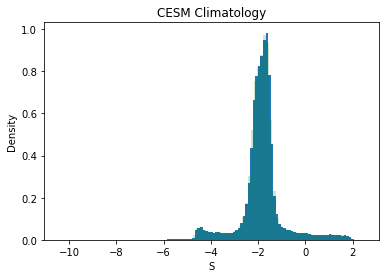

In [19]:
## Histograms of CESM
mod_log_trans = np.log(dsmod.Chl_surf.where(dsmod.Chl_surf>0))
mod2_log_trans = np.log(dsmod2.Chl_surf.where(dsmod2.Chl_surf>0))
plt.figure()
plt.hist(mod_log_trans.values.ravel(), 100, density=True, label='1986-2005');
plt.hist(mod2_log_trans.values.ravel(), 100, density=True, alpha =0.2, color='green', label='1997-2005');
plt.title('CESM Climatology')
plt.xlabel('S')
plt.ylabel('Density');

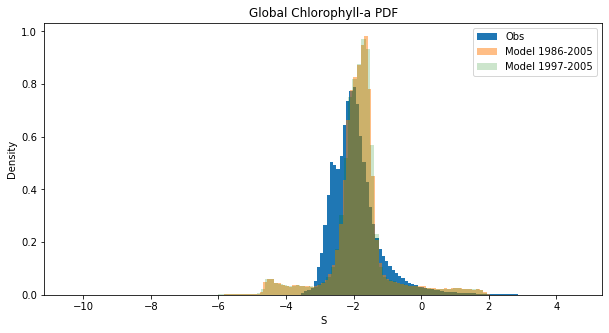

In [21]:
S_obs = obs_log_trans.values.ravel()
S_sim = mod_log_trans.values.ravel()

plt.figure(figsize=(10, 5))
plt.hist(S_obs, 100, density=True, label='Obs');
plt.hist(S_sim, 100, density=True, alpha=0.5, label='Model 1986-2005');
plt.hist(mod2_log_trans.values.ravel(), 100, density=True, alpha =0.2, color='green', label='Model 1997-2005');
plt.xlabel('S')
plt.title('Global Chlorophyll-a PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig(save_path+'model vs obs chl compare feb 5.png')

## Make Regional PDFs

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


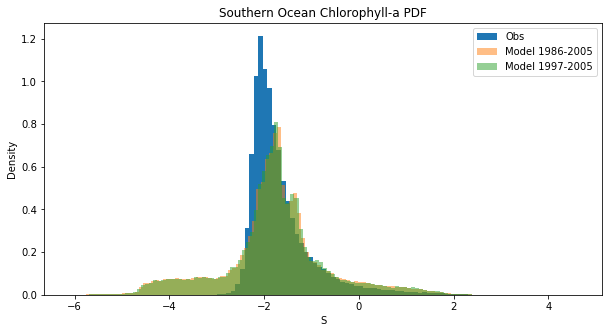

In [22]:
#Subset to Southern Ocean
ds_ob_so = dsobs.where(dsobs.TLAT <= -45)
ds_mod_so = dsmod.where(dsmod.TLAT <= -45)
ds_mod2_so = dsmod2.where(dsmod.TLAT <= -45)

#Log transform the data
mod_log_trans = np.log(ds_mod_so.Chl_surf.where(ds_mod_so.Chl_surf>0 & (ds_mod_so.TLAT <= -45)))
mod2_log_trans = np.log(ds_mod2_so.Chl_surf.where(ds_mod2_so.Chl_surf>0 & (ds_mod2_so.TLAT <= -45)))
obs_log_trans = np.log(ds_ob_so.chl_gsm.where(ds_ob_so.chl_gsm>0 & (ds_ob_so.TLAT <= -45)))
#Make them a vector
S_obs = obs_log_trans.values.ravel()
S_sim = mod_log_trans.values.ravel()
S_sim2 = mod2_log_trans.values.ravel()
#Plot!
plt.figure(figsize=(10, 5))
plt.hist(S_obs, 100, density=True, label='Obs');
plt.hist(S_sim, 100, density=True, alpha=0.5, label='Model 1986-2005');
plt.hist(S_sim2, 100, density=True, alpha=0.5, label='Model 1997-2005');
plt.xlabel('S')
plt.title('Southern Ocean Chlorophyll-a PDF')
plt.ylabel('Density');
plt.legend();
#plt.savefig(save_path+'model vs obs chl compare feb 5.png')

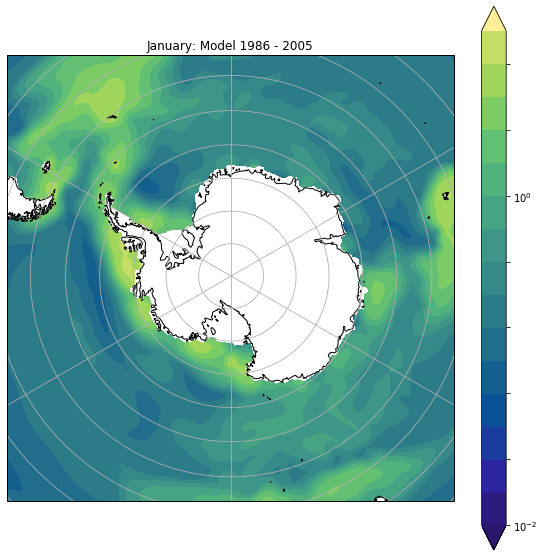

In [23]:
#PLOT IT
dsp = util.pop_add_cyclic(dsmod)

lon, lat = dsp.TLONG.isel(nlat=slice(0, 100)), dsp.TLAT.isel(nlat=slice(0, 100)) 
field = dsp.Chl_surf.isel(month=0, nlat=slice(0, 100))
#field = np.log(dsp.Chl_surf.isel(month=0, nlat=slice(0, 100)))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cmap = cmocean.cm.haline
levels = np.logspace(-2, 1, 16)
norm = colors.LogNorm(vmin=0.01, vmax=20.)

cf = ax.contourf(lon, lat, field,
                 levels=levels,
                 cmap=cmap,
                 extend='both',
                 norm=norm,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines().n_steps = 90  ## this makes them rounder
#plt.title('January Model Output np.log ')
plt.title('January: Model 1986 - 2005')

#plt.title('January Model Output')
fig.colorbar(cf, ax=ax)

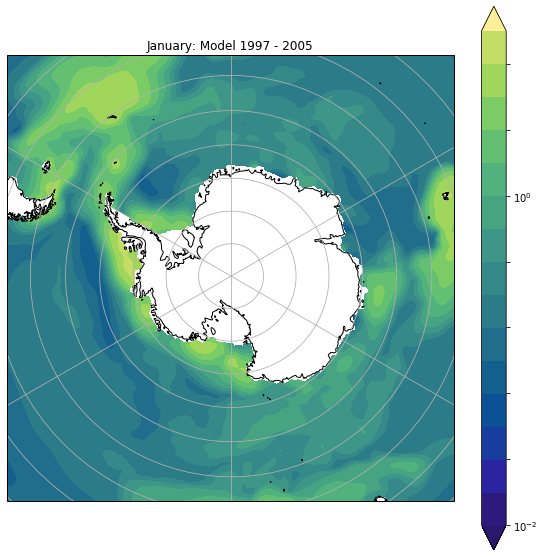

In [24]:
#PLOT IT
dsp3 = util.pop_add_cyclic(dsmod2)

lon, lat = dsp3.TLONG.isel(nlat=slice(0, 100)), dsp3.TLAT.isel(nlat=slice(0, 100)) 
field = dsp3.Chl_surf.isel(month=0, nlat=slice(0, 100))
#field = np.log(dsp.Chl_surf.isel(month=0, nlat=slice(0, 100)))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cmap = cmocean.cm.haline
levels = np.logspace(-2, 1, 16)
norm = colors.LogNorm(vmin=0.01, vmax=20.)

cf = ax.contourf(lon, lat, field,
                 levels=levels,
                 cmap=cmap,
                 extend='both',
                 norm=norm,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines().n_steps = 90  ## this makes them rounder
#plt.title('January Model Output np.log ')
plt.title('January: Model 1997 - 2005')

#plt.title('January Model Output')
fig.colorbar(cf, ax=ax)

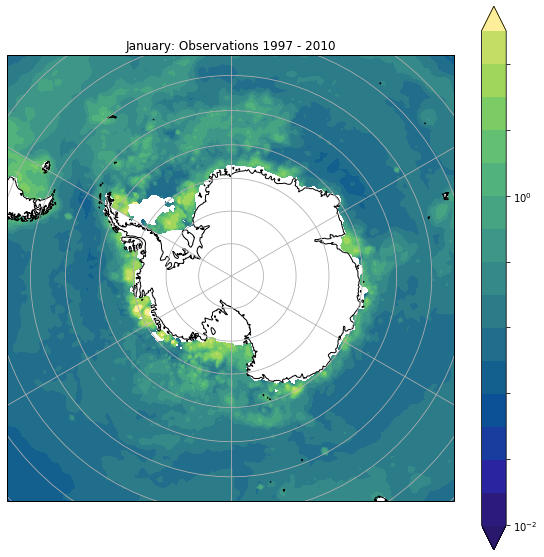

In [26]:
#PLOT IT
dsp = util.pop_add_cyclic(dsobs)

#Data:
lon = dsp.TLONG.isel(nlat=slice(0, 100))
lat = dsp.TLAT.isel(nlat=slice(0, 100)) 
field = dsp.chl_gsm.isel(month=0, nlat=slice(0, 100))

#Set up Figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([180, -180, -75,  -50], crs=ccrs.PlateCarree())

cmap = cmocean.cm.haline
norm = colors.LogNorm(vmin=0.01, vmax=20.)
levels = np.logspace(-2, 1, 16)

cf = ax.contourf(lon, lat, field,
                 levels=levels,
                 cmap=cmap,
                 extend='both',
                 norm=norm,
                 transform=ccrs.PlateCarree())

ax.coastlines('50m')
ax.gridlines().n_steps = 90  ## this makes them rounder
#plt.title('January Model Output np.log ')
plt.title('January: Observations 1997 - 2010')

#plt.title('January Model Output')
fig.colorbar(cf, ax=ax)

## Map out Things

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


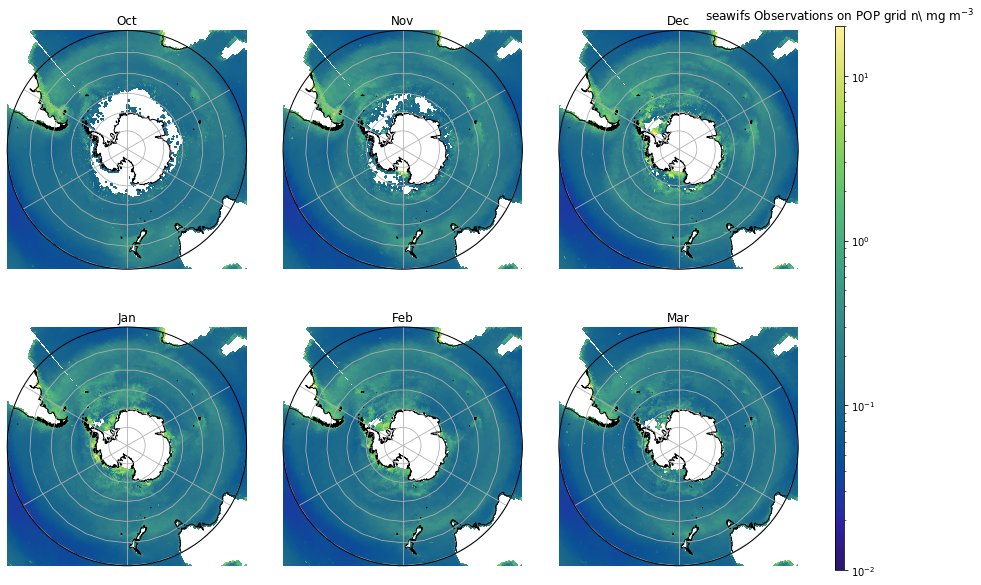

In [27]:
cmap = cmocean.cm.haline
levels = np.logspace(-2, 1, 16)
norm = colors.LogNorm(vmin=0.01, vmax=20.)

lat = dsobs.TLAT.values
lon = dsobs.TLONG.values

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 0.04))

for i, mon in enumerate(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']):   

    row, col = np.unravel_index(i, (2, 3))
    
    ax = fig.add_subplot(gs[row, col], projection=ccrs.SouthPolarStereo())
    ax.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())

    data = dsobs.chl_gsm.sel(month=mon).values
    
    cf = ax.pcolormesh(lon, lat, data,
                       cmap=cmap,
                       norm=norm,
                       transform=ccrs.PlateCarree())

    ax.coastlines('50m')
    ax.gridlines()

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

    ax.set_title(mon)
    
cax = fig.add_subplot(gs[:, -1])    
cb = plt.colorbar(cf, cax=cax)
cb.ax.set_title('seawifs Observations on POP grid n\ mg m$^{-3}$');

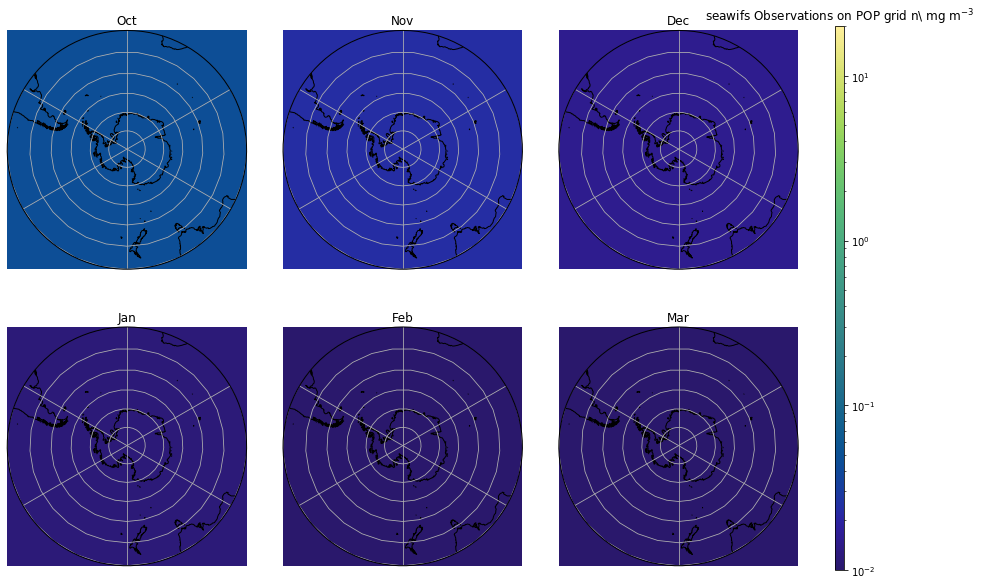

In [29]:
dsp = util.pop_add_cyclic(dsmod2)

cmap = cmocean.cm.haline
levels = np.logspace(-2, 1, 16)
norm = colors.LogNorm(vmin=0.01, vmax=20.)

lat = dsp.TLAT.values
lon = dsp.TLONG.values

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 0.04))

for i, mon in enumerate(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']):   

    row, col = np.unravel_index(i, (2, 3))
    
    ax = fig.add_subplot(gs[row, col], projection=ccrs.SouthPolarStereo())
    ax.set_extent([180, -180, -90,  -30], crs=ccrs.PlateCarree())

    data = dsp.Chl_surf.sel(month=mon).values
    
    cf = ax.pcolormesh(lon, lat, data,
                       cmap=cmap,
                       norm=norm,
                       transform=ccrs.PlateCarree())

    ax.coastlines('50m')
    ax.gridlines()

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

    ax.set_title(mon)
    
cax = fig.add_subplot(gs[:, -1])    
cb = plt.colorbar(cf, cax=cax)
cb.ax.set_title('seawifs Observations on POP grid n\ mg m$^{-3}$');

## REGIONALIZE


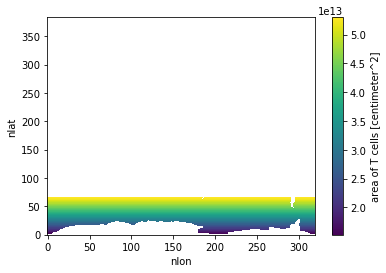

In [96]:
SO_mask = dsmod.TAREA.where((dsmod.TLAT <= -44) & (dsmod.KMT > 0))
SO_mask.plot()

AttributeError: 'DataArray' object has no attribute 'chl_gsm'

# Kristen's Example Use of POP-TOOLS for regions

In [142]:
mos = np.arange(len(dsobs.month))

Set up region mask for major basins


In [37]:
grid_name = 'POP_gx1v7'
ds_regmasks = pop_tools.get_grid(grid_name)

In [38]:
region_masks = pop_tools.list_region_masks(grid_name)
region_mask='Pacific-Indian-Atlantic'
mask3d = pop_tools.region_mask_3d(grid_name, mask_name=region_mask)

In [39]:
region_defs = {'Atlantic SO': [{'match':
                             {'REGION_MASK': [1]},
                            'bounds':
                             {'TLAT': [-90., -44.], 'TLONG': [292., 20.]}}],
               'Pacific SO': [{'match':
                             {'REGION_MASK': [1]},
                            'bounds':
                             {'TLAT': [-90., -44.], 'TLONG': [147., 292.]}}],
              'Indian SO':  [{'match':
                             {'REGION_MASK': [1]},
                            'bounds':
                             {'TLAT': [-90., -44.], 'TLONG': [20., 147.]}}],}

mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs,
                                  mask_name='Southern Ocean Quadrants')

#### Indian

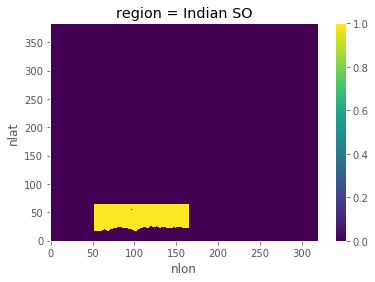

In [57]:
regnum=2
mask3d.isel(region=regnum).plot();

In [60]:
ds_in = xr.Dataset({v: dsmod[v] for v in ['month']})
ds_in['Chl_surf']= esmlab.weighted_mean(dsmod['Chl_surf']*mask3d.isel(region=regnum), weights=dsmod.TAREA, dim=['nlat', 'nlon']).compute()

ds_in_obs = xr.Dataset({v: dsobs[v] for v in ['month']})
ds_in_obs['chl_gsm']= esmlab.weighted_mean(dsobs['chl_gsm']*mask3d.isel(region=regnum), weights=dsobs.TAREA, dim=['nlat', 'nlon']).compute()

#### Pacific


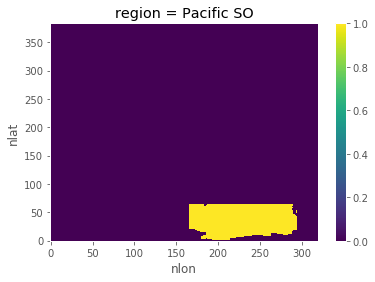

In [61]:
regnum=1
mask3d.isel(region=regnum).plot();

In [62]:
ds_pac = xr.Dataset({v: dsmod[v] for v in ['month']})
ds_pac['Chl_surf']= esmlab.weighted_mean(dsmod['Chl_surf']*mask3d.isel(region=regnum), weights=dsmod.TAREA, dim=['nlat', 'nlon']).compute()

ds_pac_obs = xr.Dataset({v: dsobs[v] for v in ['month']})
ds_pac_obs['chl_gsm']= esmlab.weighted_mean(dsobs['chl_gsm']*mask3d.isel(region=regnum), weights=dsobs.TAREA, dim=['nlat', 'nlon']).compute()

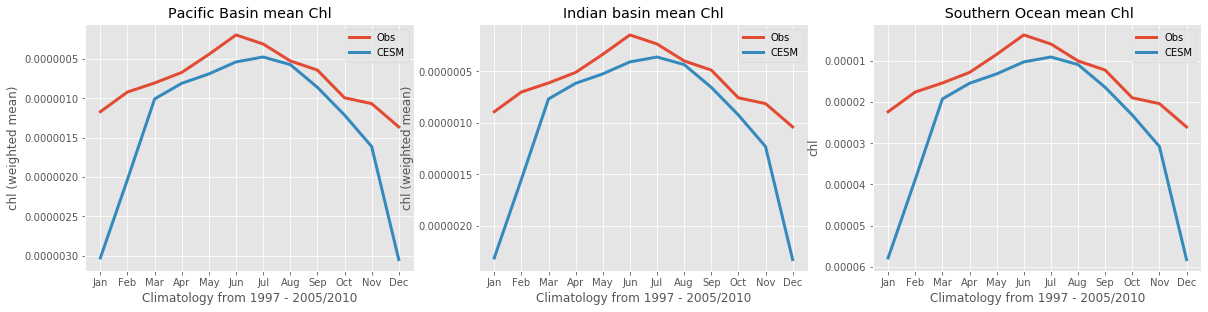

In [66]:
fig = plt.figure(figsize=(20,10))

#COLUMN 1  - CHL Pacific

ax = fig.add_subplot(2,3,1)
ax.set_title('Pacific Basin mean Chl')
ax.plot(ds_pac_obs['month'].values, ds_pac_obs['chl_gsm'].values, label='Obs',linewidth=3)
ax.plot(ds_pac['month'].values, ds_pac['Chl_surf'].values, label='CESM',linewidth=3)
ax.legend()
ax.set(ylabel='chl (weighted mean)',xlabel='Climatology from 1997 - 2005/2010')
plt.gca().invert_yaxis()

ax = fig.add_subplot(2,3,2)
ax.set_title('Indian basin mean Chl')
ax.plot(ds_in_obs['month'].values, ds_in_obs['chl_gsm'].values, label='Obs',linewidth=3)
ax.plot(ds_in['month'].values, ds_in['Chl_surf'].values, label='CESM',linewidth=3)
ax.legend()
ax.set(ylabel='chl (weighted mean)',xlabel='Climatology from 1997 - 2005/2010')
plt.gca().invert_yaxis()

ax = fig.add_subplot(2,3,3)
ax.set_title(' Southern Ocean mean Chl')
ax.plot(dsobs['month'].values, dsobs['chl_gsm'].values, label='Obs',linewidth=3)
ax.plot(dsmod['month'].values, dsmod['Chl_surf'].values, label='CESM',linewidth=3)
ax.legend()
ax.set(ylabel='chl',xlabel='Climatology from 1997 - 2005/2010')
plt.gca().invert_yaxis()

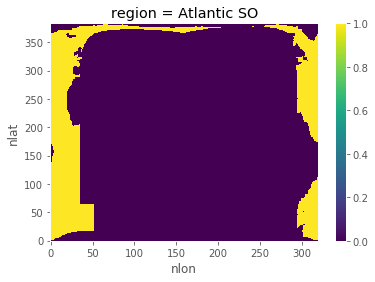

In [64]:
regnum=0
mask3d.isel(region=regnum).plot();

Look at chl by basin


In [65]:
ds_at = xr.Dataset({v: dsmod[v] for v in ['month']})
ds_at['Chl_surf']= esmlab.weighted_mean(dsmod['Chl_surf']*mask3d.isel(region=regnum), weights=dsmod.TAREA, dim=['nlat', 'nlon']).compute()

ds_at_obs = xr.Dataset({v: dsobs[v] for v in ['month']})
ds_at_obs['chl_gsm']= esmlab.weighted_mean(dsobs['chl_gsm']*mask3d.isel(region=regnum), weights=dsobs.TAREA, dim=['nlat', 'nlon']).compute()

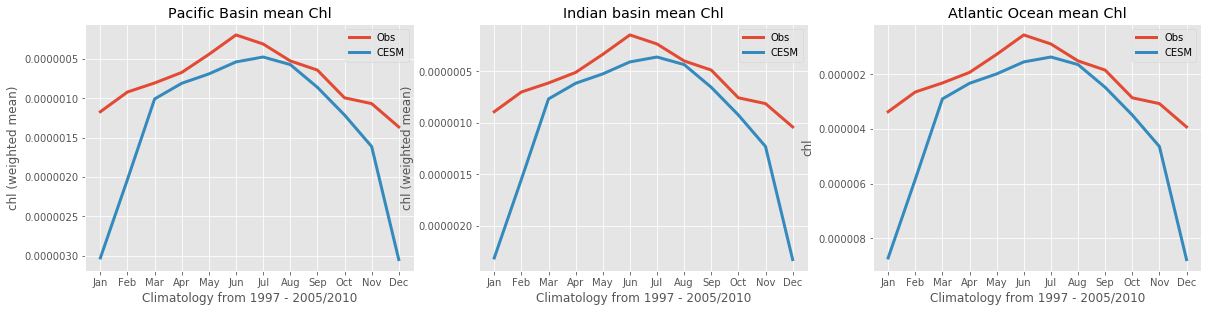

In [67]:
fig = plt.figure(figsize=(20,10))

#COLUMN 1  - CHL Pacific

ax = fig.add_subplot(2,3,1)
ax.set_title('Pacific Basin mean Chl')
ax.plot(ds_pac_obs['month'].values, ds_pac_obs['chl_gsm'].values, label='Obs',linewidth=3)
ax.plot(ds_pac['month'].values, ds_pac['Chl_surf'].values, label='CESM',linewidth=3)
ax.legend()
ax.set(ylabel='chl (weighted mean)',xlabel='Climatology from 1997 - 2005/2010')
plt.gca().invert_yaxis()

ax = fig.add_subplot(2,3,2)
ax.set_title('Indian basin mean Chl')
ax.plot(ds_in_obs['month'].values, ds_in_obs['chl_gsm'].values, label='Obs',linewidth=3)
ax.plot(ds_in['month'].values, ds_in['Chl_surf'].values, label='CESM',linewidth=3)
ax.legend()
ax.set(ylabel='chl (weighted mean)',xlabel='Climatology from 1997 - 2005/2010')
plt.gca().invert_yaxis()

ax = fig.add_subplot(2,3,3)
ax.set_title('Atlantic Ocean mean Chl')
ax.plot(ds_at_obs['month'].values, ds_at_obs['chl_gsm'].values, label='Obs',linewidth=3)
ax.plot(ds_at['month'].values, ds_at['Chl_surf'].values, label='CESM',linewidth=3)
ax.legend()
ax.set(ylabel='chl',xlabel='Climatology from 1997 - 2005/2010')
plt.gca().invert_yaxis()